In [1]:
#libraries for data wrangling
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2 #computer vision
import os  #directory

#libraries for modelling
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
#data
from tensorflow.keras.datasets import cifar10


#model building
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import sys
from tensorflow.keras.utils import to_categorical


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


# Normalizing pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# data types and shapes
print("Training images:", type(x_train), x_train.shape)
print("Training labels:", type(y_train), y_train.shape)
print("Test images:", type(x_test), x_test.shape)
print("Test labels:", type(y_test), y_test.shape)

Training images: <class 'numpy.ndarray'> (50000, 32, 32, 3)
Training labels: <class 'numpy.ndarray'> (50000, 1)
Test images: <class 'numpy.ndarray'> (10000, 32, 32, 3)
Test labels: <class 'numpy.ndarray'> (10000, 1)


Example class names: ['airplane', 'automobile', 'bird', 'cat', 'deer']


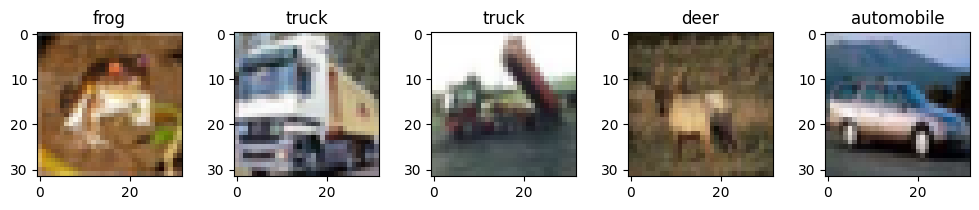

In [4]:
# Exploring class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("Example class names:", class_names[:5])  # Print first 5 class names

num_samples = 5
plt.figure(figsize=(10, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i][0]])  # Assuming categorical labels, access the first element
plt.tight_layout()
plt.show()

# EDA and Pre-processing

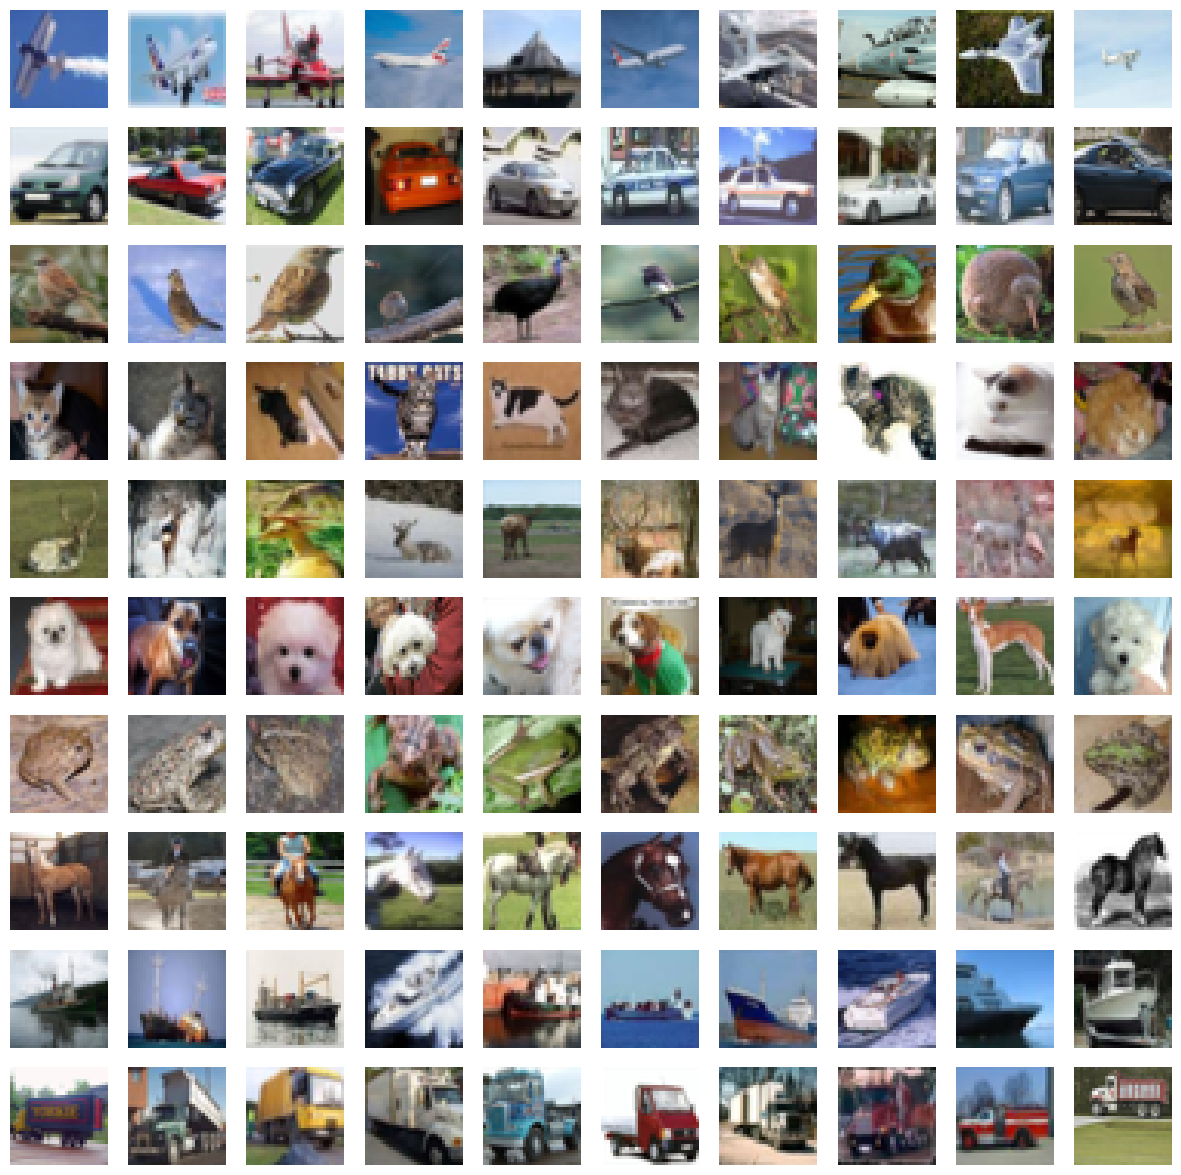

In [5]:
#Sample Images per Class

def plot_samples_per_class(x, y, class_names):
    plt.figure(figsize=(15, 15))
    for i in range(10):
        idxs = np.where(y == i)[0]
        idxs = np.random.choice(idxs, 10, replace=False)
        for j in range(10):
            plt_idx = i * 10 + j + 1
            plt.subplot(10, 10, plt_idx)
            plt.imshow(x[idxs[j]])
            plt.axis('off')
            if j == 0:
                plt.ylabel(class_names[i], rotation=0, size='large')
    plt.show()
plot_samples_per_class(x_train, y_train, class_names)

In [7]:
#Image Size and Aspect Ratio Consistency

image_shapes = [img.shape for img in x_train]
unique_shapes = np.unique(image_shapes, axis=0)
print(f'Unique image shapes: {unique_shapes}')

Unique image shapes: [[32 32  3]]


Mean of pixel values (RGB): [0.4914009  0.48215896 0.4465308 ]
Standard deviation of pixel values (RGB): [0.24703279 0.24348423 0.26158753]


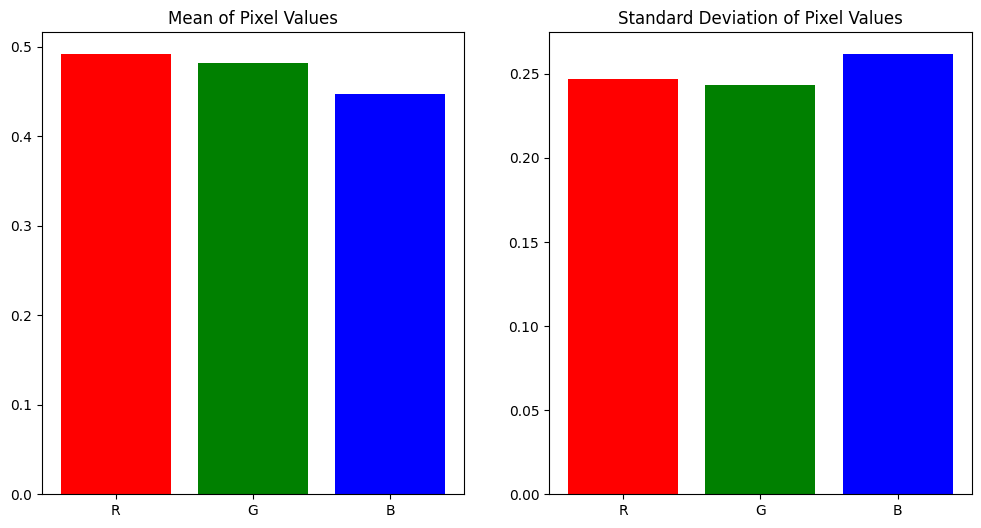

In [8]:
#Mean and Standard Deviation of Pixel Values

mean = np.mean(x_train, axis=(0, 1, 2))
std = np.std(x_train, axis=(0, 1, 2))

print(f'Mean of pixel values (RGB): {mean}')
print(f'Standard deviation of pixel values (RGB): {std}')

colors = ["#00AE9F", "#E4A307", "#7D4E24"]  # Select first 3 colors for RGB channels

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(['R', 'G', 'B'], mean, color=['red', 'green', 'blue'])
ax[0].set_title('Mean of Pixel Values')
ax[1].bar(['R', 'G', 'B'], std, color=['red', 'green', 'blue'])
ax[1].set_title('Standard Deviation of Pixel Values')
plt.show()

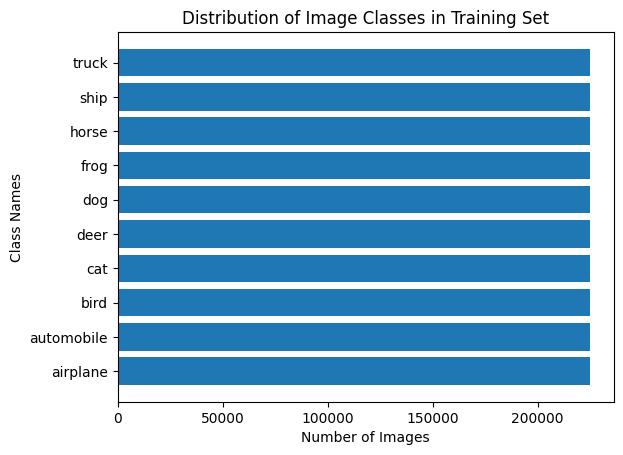

In [9]:
#Image Distribution across the classes

class_counts = y_train.sum(axis = 0)
plt.barh(class_names, class_counts)
plt.xlabel("Number of Images")
plt.ylabel("Class Names")
plt.title("Distribution of Image Classes in Training Set")
plt.show()

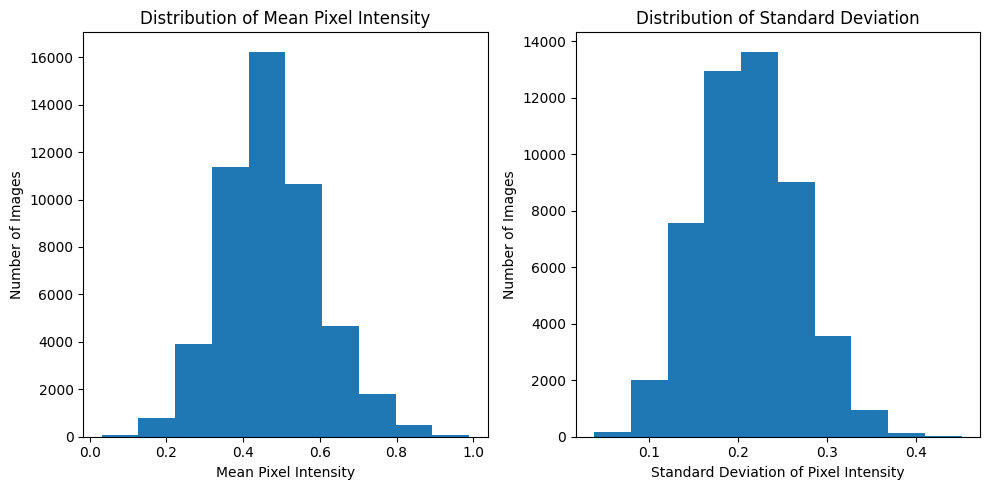

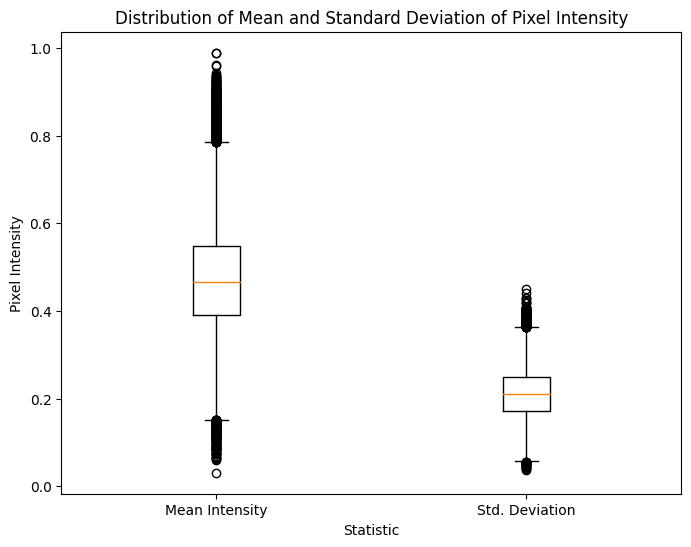

In [10]:
#Distribution of Pixel Intensities

flat_images = x_train.reshape(-1, 32 * 32 * 3)
mean_intensities = flat_images.mean(axis=1)
std_intensities = flat_images.std(axis=1)

# Visualizing mean and standard deviation

# Option 1: Histograms
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(mean_intensities)
plt.xlabel("Mean Pixel Intensity")
plt.ylabel("Number of Images")
plt.title("Distribution of Mean Pixel Intensity")

plt.subplot(1, 2, 2)
plt.hist(std_intensities)
plt.xlabel("Standard Deviation of Pixel Intensity")
plt.ylabel("Number of Images")
plt.title("Distribution of Standard Deviation")
plt.tight_layout()
plt.show()

# Option 2: Boxplots
plt.figure(figsize=(8, 6))
plt.boxplot([mean_intensities, std_intensities], labels=["Mean Intensity", "Std. Deviation"])
plt.xlabel("Statistic")
plt.ylabel("Pixel Intensity")
plt.title("Distribution of Mean and Standard Deviation of Pixel Intensity")
plt.show()


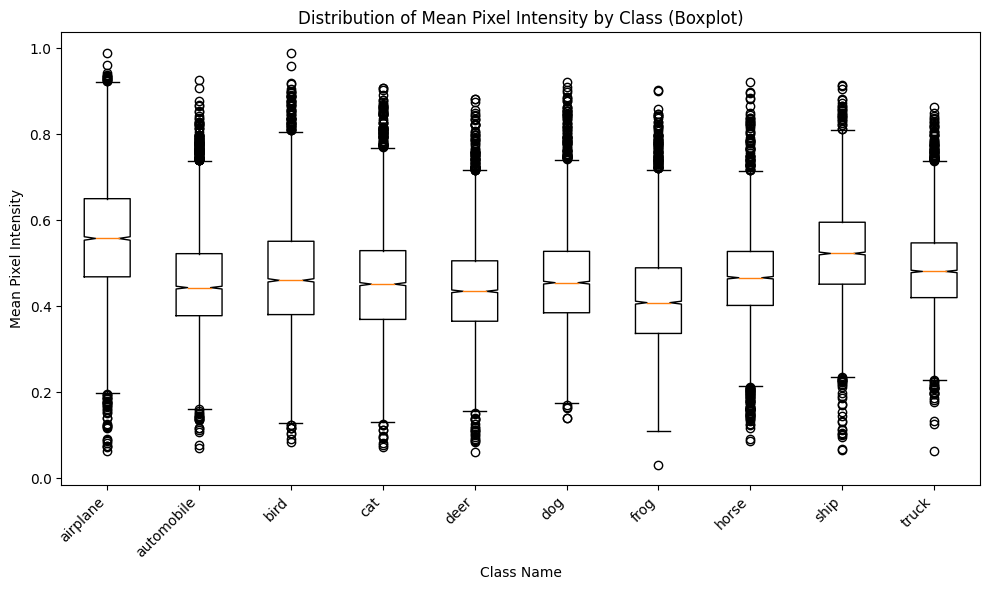

In [11]:
#Visualizing mean and SD for the intensity
num_classes = len(class_names)
class_wise_means = []
class_wise_stds = []
for i in range(num_classes):
    class_indices = (y_train == i).reshape(-1,)  # Find indices for this class
    class_images = x_train[class_indices]
    # Calculate mean and standard deviation for this class
    class_wise_means.append(class_images.mean(axis=(1, 2, 3)))
    class_wise_stds.append(class_images.std(axis=(1, 2, 3)))

# Boxplots
plt.figure(figsize=(10, 6))
plt.boxplot(class_wise_means, labels=class_names, notch=True)  # Adding notch for better comparison
plt.xlabel("Class Name")
plt.ylabel("Mean Pixel Intensity")
plt.title("Distribution of Mean Pixel Intensity by Class (Boxplot)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




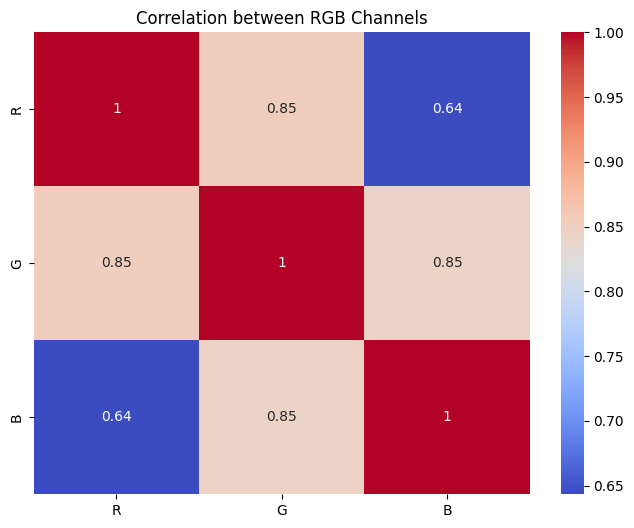

In [12]:
#Correlation between Channels
reshaped_x_train = x_train.reshape(-1, 32*32, 3)

# Calculating the correlation matrix for the RGB channels
correlation_matrix = np.corrcoef(reshaped_x_train.mean(axis=1), rowvar=False)


import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=['R', 'G', 'B'], yticklabels=['R', 'G', 'B'])
plt.title('Correlation between RGB Channels')
plt.show()

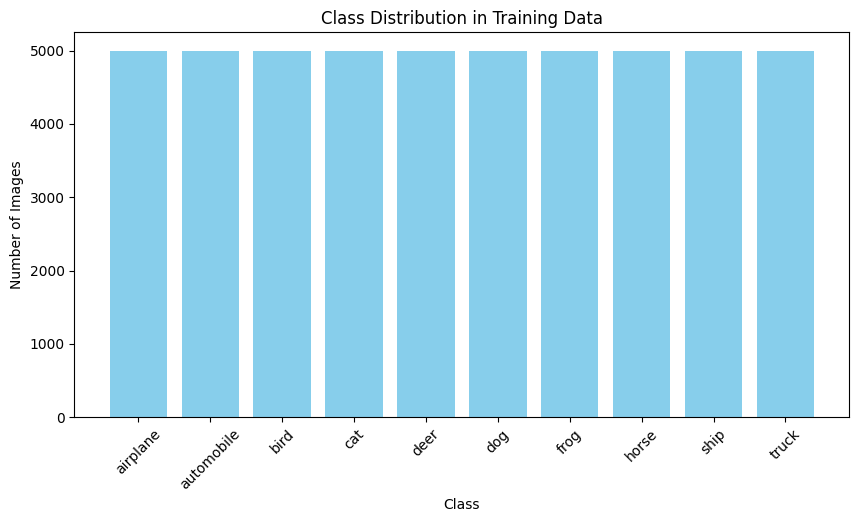

Class counts: {'airplane': 5000, 'automobile': 5000, 'bird': 5000, 'cat': 5000, 'deer': 5000, 'dog': 5000, 'frog': 5000, 'horse': 5000, 'ship': 5000, 'truck': 5000}


In [13]:
#Class Imbalance Analysis
"""
Analyzing the distribution of images across different classes helps to identify any class imbalances
 that may need to be addressed during model training.
"""

class_counts = np.bincount(y_train.flatten())

plt.figure(figsize=(10, 5))
plt.bar(class_names, class_counts, color='skyblue')
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

print(f'Class counts: {dict(zip(class_names, class_counts))}')

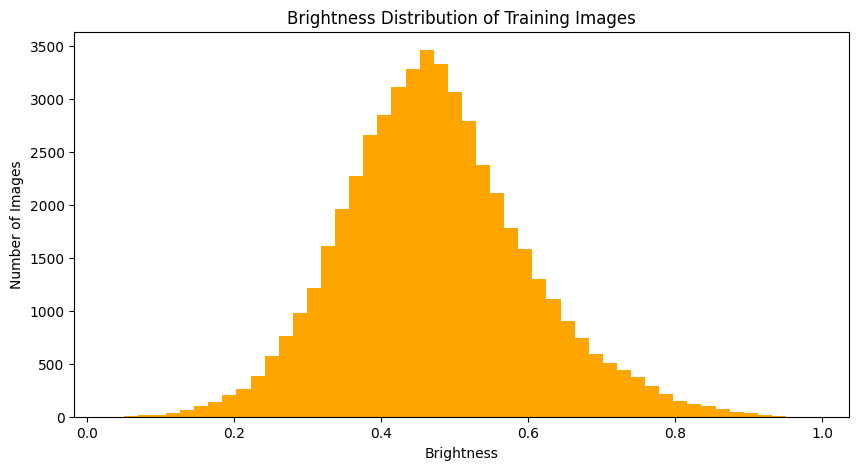

In [14]:
#Image brightness


"""
This script calculates the average brightness (mean of pixel values)
across all channels (RGB) for each image in the training data (x_train)
and visualizes the distribution of these brightness values using a histogram.

Analyzing the brightness of images can provide insights into the overall
lighting conditions in the dataset, which might affect the model's performance.
For instance, a dataset with predominantly dark images could lead the model
to struggle with identifying objects in brighter environments.
Visualizing the brightness distribution can help identify potential biases
in the data and inform decisions about data augmentation techniques
to improve the model'sgeneralizability.
"""

brightness = np.mean(x_train, axis=(1, 2, 3))

# Plot the distribution of brightness (unchanged)
plt.figure(figsize=(10, 5))
plt.hist(brightness, bins=50, color='orange')
plt.title('Brightness Distribution of Training Images')
plt.xlabel('Brightness')
plt.ylabel('Number of Images')
plt.show()


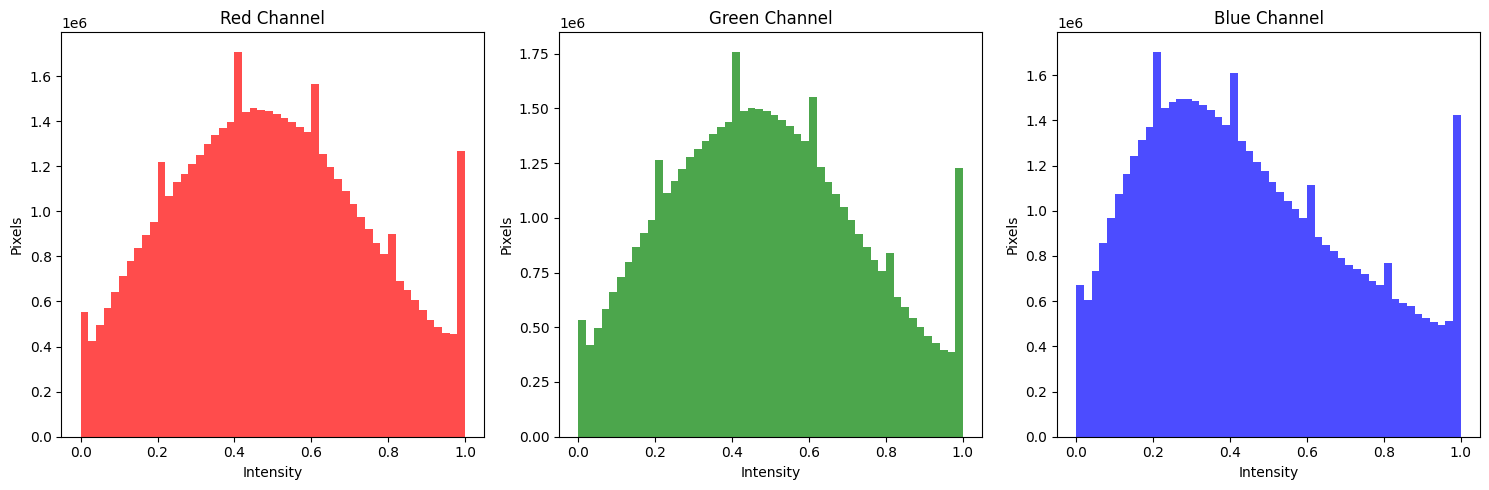

In [15]:
#Color Channel Intensity Distribution
plt.figure(figsize=(15, 5))

for i, color in enumerate(['red', 'green', 'blue']):
  plt.subplot(1, 3, i+1)
  plt.hist(x_train[:, :, :, i].flatten(), bins=50, color=color, alpha=0.7)
  plt.title(f'{color.capitalize()} Channel')
  plt.xlabel('Intensity')
  plt.ylabel('Pixels')

plt.tight_layout()
plt.show()


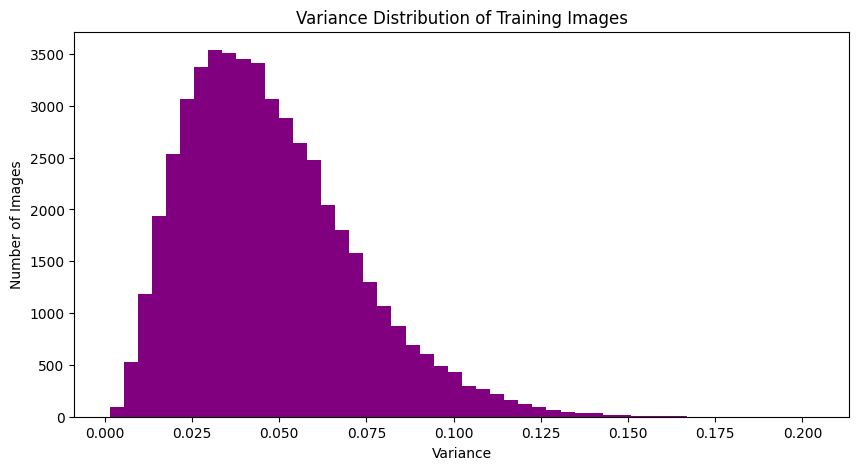

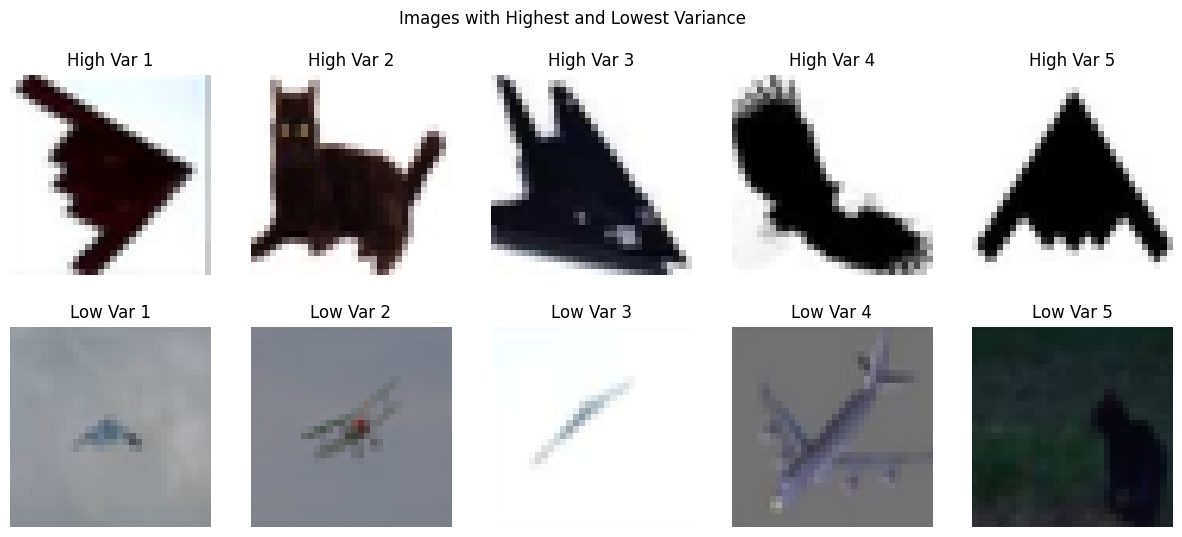

In [16]:
#Image Variance Analysis

# Calculating the variance of pixel values for each image
image_variance = np.var(x_train, axis=(1, 2, 3))


plt.figure(figsize=(10, 5))
plt.hist(image_variance, bins=50, color='purple')
plt.title('Variance Distribution of Training Images')
plt.xlabel('Variance')
plt.ylabel('Number of Images')
plt.show()

# D some images with the highest and lowest variance
high_variance_idxs = np.argsort(image_variance)[-5:]
low_variance_idxs = np.argsort(image_variance)[:5]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(high_variance_idxs):
    axes[0, i].imshow(x_train[idx])
    axes[0, i].set_title(f'High Var {i+1}')
    axes[0, i].axis('off')
for i, idx in enumerate(low_variance_idxs):
    axes[1, i].imshow(x_train[idx])
    axes[1, i].set_title(f'Low Var {i+1}')
    axes[1, i].axis('off')

plt.suptitle('Images with Highest and Lowest Variance')
plt.show()


In [17]:
#importing the pre-processing file
import os
print(os.listdir())


['Image_Classification.ipynb']


In [19]:
print(os.listdir())

['Image_Classification.ipynb']


Training set shape: (50000, 32, 32, 3), (50000, 1)
Test set shape: (10000, 32, 32, 3), (10000, 1)


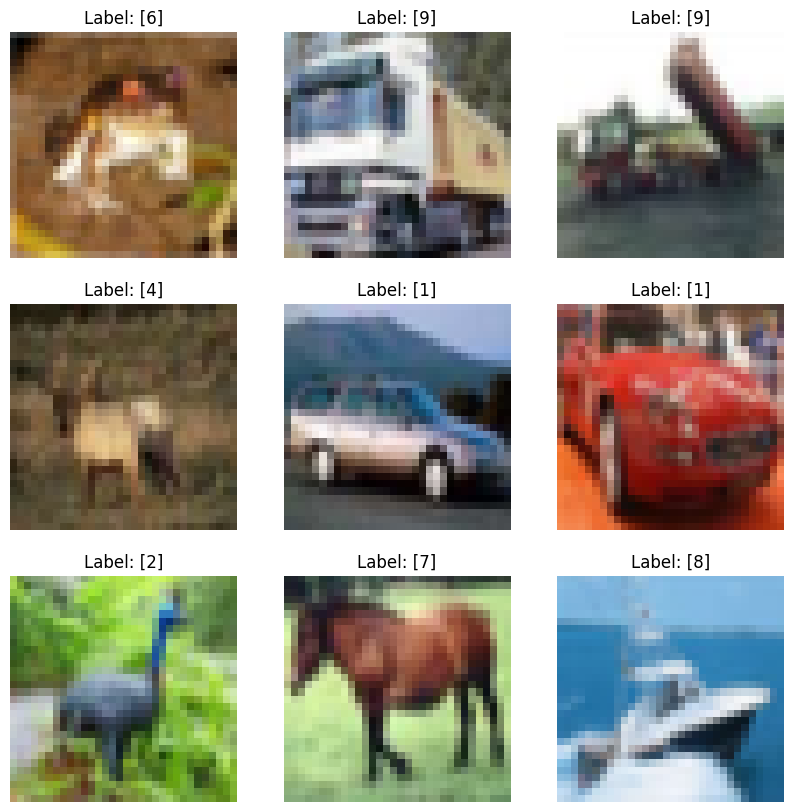

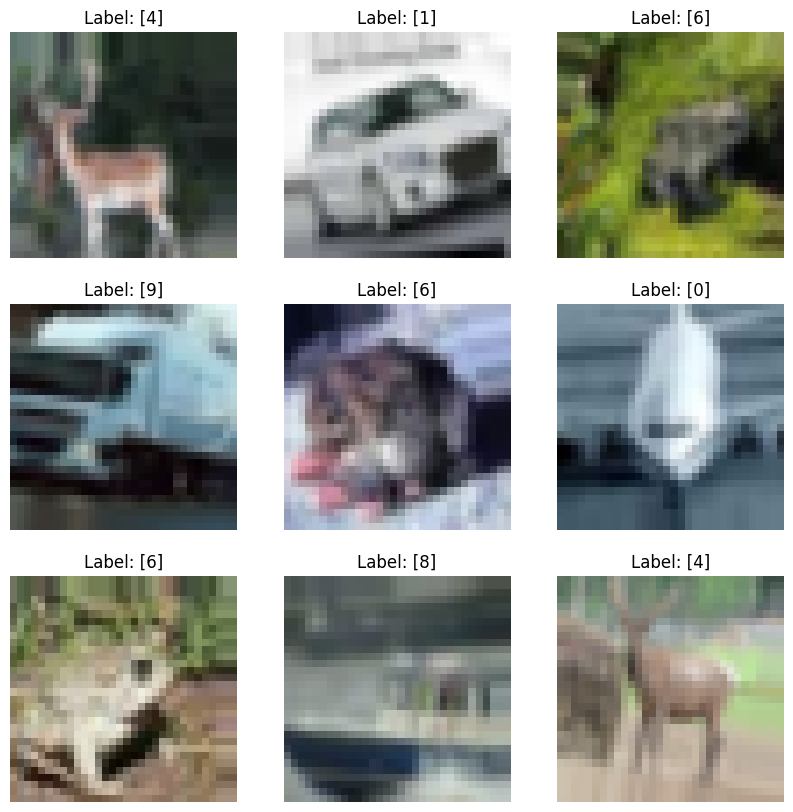

In [21]:
#works for Colab but not VS code 
# import numpy as np
# import matplotlib.pyplot as plt
# from preprocess import load_data, normalize_data, create_data_generator

# x_train, y_train, x_test, y_test = load_data()
# x_train_normalized, x_test_normalized = normalize_data(x_train, x_test)
# print(f'Training set shape: {x_train_normalized.shape}, {y_train.shape}')
# print(f'Test set shape: {x_test_normalized.shape}, {y_test.shape}')

# plt.figure(figsize=(10, 10))
# for i in range(9):
#     plt.subplot(3, 3, i + 1)
#     plt.imshow(x_train_normalized[i])
#     plt.title(f'Label: {y_train[i]}')
#     plt.axis('off')
# plt.show()

# datagen = create_data_generator()
# datagen.fit(x_train_normalized)

# plt.figure(figsize=(10, 10))
# for x_batch, y_batch in datagen.flow(x_train_normalized, y_train, batch_size=9):
#     for i in range(9):
#         plt.subplot(3, 3, i + 1)
#         plt.imshow(x_batch[i])
#         plt.title(f'Label: {y_batch[i]}')
#         plt.axis('off')
#     plt.show()
#     break
#----------------------------------------------------------------> exclusively for VS Code


# Add the main directory (Image-Classification) to the Python path
current_dir = os.path.dirname(os.path.realpath('__file__'))
main_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(main_dir)

# Import from the preprocess module
from data.preprocess import load_data, normalize_data, create_data_generator

# Load and preprocess data
x_train, y_train, x_test, y_test = load_data()
x_train_normalized, x_test_normalized = normalize_data(x_train, x_test)

print(f'Training set shape: {x_train_normalized.shape}, {y_train.shape}')
print(f'Test set shape: {x_test_normalized.shape}, {y_test.shape}')

# Plot some samples from the training set
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train_normalized[i])
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.show()

# Create a data generator and plot some augmented images
datagen = create_data_generator()
datagen.fit(x_train_normalized)

plt.figure(figsize=(10, 10))
for x_batch, y_batch in datagen.flow(x_train_normalized, y_train, batch_size=9):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x_batch[i])
        plt.title(f'Label: {y_batch[i]}')
        plt.axis('off')
    plt.show()
    break




# Baseline Model

In [22]:
x_train, y_train, x_test, y_test = load_data()
x_train_normalized, x_test_normalized = normalize_data(x_train, x_test)

# Splitting the normalized training data into training and validation sets
x_train_normalized, x_val_normalized, y_train, y_val = train_test_split(x_train_normalized, y_train, test_size=0.2, random_state=42)

print(f'Training set shape: {x_train_normalized.shape}, {y_train.shape}')
print(f'Validation set shape: {x_val_normalized.shape}, {y_val.shape}')
print(f'Test set shape: {x_test_normalized.shape}, {y_test.shape}')

# One-hot encoding
y_train = tf.one_hot(y_train, depth=10)
y_train = y_train[:, 0]  # Remove extra dimension

print(f'y_val shape before one-hot: {y_val.shape}')
y_val = y_val.reshape(-1)
y_val = tf.one_hot(y_val, depth=10)
print(f'y_val shape after one-hot: {y_val.shape}')



Training set shape: (40000, 32, 32, 3), (40000, 1)
Validation set shape: (10000, 32, 32, 3), (10000, 1)
Test set shape: (10000, 32, 32, 3), (10000, 1)
y_val shape before one-hot: (10000, 1)
y_val shape after one-hot: (10000, 10)


In [26]:

def create_baseline_model(input_shape, num_classes=10):
  """
  Creates a baseline CNN model for image classification.

  Args:
      input_shape (tuple): Input shape of the images (height, width, channels).
      num_classes (int): Number of classes for classification.

  Returns:
      model (tf.keras.Model): Compiled CNN model.
  """
  model = tf.keras.Sequential()
  chanDim = -1
  model.add(tf.keras.layers.Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
  model.add(tf.keras.layers.Activation("relu"))
  model.add(tf.keras.layers.BatchNormalization(axis=chanDim))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))
  model.add(tf.keras.layers.Dropout(0.25))
  # ... (rest of the convolutional layers)
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(tf.keras.layers.Flatten())  # Added Flatten layer
  model.add(tf.keras.layers.Dense(1024))
  model.add(tf.keras.layers.Activation("relu"))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(num_classes))
  model.add(tf.keras.layers.Activation("softmax"))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model


def train_model(model, x_train, y_train, x_val, y_val, epochs=5, batch_size=32):
    """
    Trains the given model using the provided training and validation data.

    Args:
        model (tf.keras.Model): Compiled CNN model.
        x_train (numpy.ndarray): Training images.
        y_train (numpy.ndarray): Training labels.
        x_val (numpy.ndarray): Validation images.
        y_val (numpy.ndarray): Validation labels.
        epochs (int): Number of epochs for training.
        batch_size (int): Batch size for training.

    Returns:
        history (tf.keras.callbacks.History): Training history.
    """
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))
    return history

# Define input shape
input_shape = x_train_normalized[0].shape


# Train the model
baseline_model = create_baseline_model(input_shape=input_shape)
baseline_history = train_model(baseline_model, x_train_normalized, y_train, x_val_normalized, y_val, epochs=10, batch_size=32)


Epoch 1/10
1250/1250 [==============================] - 92s 72ms/step - loss: 1.7409 - accuracy: 0.4195 - val_loss: 1.4348 - val_accuracy: 0.4928
Epoch 2/10
1250/1250 [==============================] - 70s 56ms/step - loss: 1.4149 - accuracy: 0.5026 - val_loss: 1.4033 - val_accuracy: 0.5539
Epoch 3/10
1250/1250 [==============================] - 74s 59ms/step - loss: 1.3499 - accuracy: 0.5246 - val_loss: 1.2118 - val_accuracy: 0.5831
Epoch 4/10
1250/1250 [==============================] - 70s 56ms/step - loss: 1.2979 - accuracy: 0.5415 - val_loss: 1.4511 - val_accuracy: 0.5460
Epoch 5/10
1250/1250 [==============================] - 85s 68ms/step - loss: 1.2568 - accuracy: 0.5580 - val_loss: 1.6528 - val_accuracy: 0.5043
Epoch 6/10
1250/1250 [==============================] - 73s 59ms/step - loss: 1.2273 - accuracy: 0.5685 - val_loss: 1.2396 - val_accuracy: 0.6047
Epoch 7/10
1250/1250 [==============================] - 108s 87ms/step - loss: 1.2028 - accuracy: 0.5788 - val_loss: 1.2719 

# Baseline Model Evaluation


In [27]:
# Evaluate the model on the test set

from tensorflow.keras.utils import to_categorical

# One-hot encode the test labels
y_test_encoded = to_categorical(y_test, num_classes=10)

print(f'Encoded shape: {y_test_encoded.shape}')
print(f'X test normalized shape: {x_test_normalized.shape}')


# test_loss, test_accuracy = baseline_model.evaluate(x_test_normalized, y_test_encoded, verbose=2)
# print(f'Test loss: {test_loss}')
# print(f'Test accuracy: {test_accuracy}')


Encoded shape: (10000, 10)
X test normalized shape: (10000, 32, 32, 3)


[INFO] Plotting model accuracy and loss


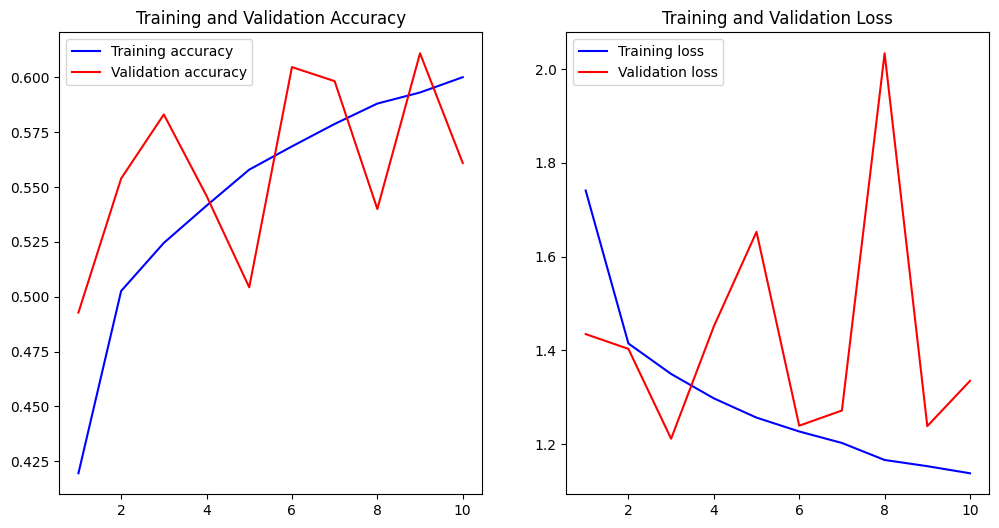

[INFO] Calculating model accuracy on test set
313/313 - 4s - loss: 1.3712 - accuracy: 0.5572 - 4s/epoch - 11ms/step
Test Accuracy: 55.72%
Test Loss: 1.3712


In [28]:

# Function to plot results and evaluate the model
def Res_Plot_Test_Save(history, model, x_test, y_test, name="model_performance"):
    """
    Plots the training and validation accuracy and loss, and evaluates the model on the test set.

    Args:
        history: History object from model training.
        model: Trained Keras model.
        x_test: Test data.
        y_test: Test labels.
        name: Name for saving the plots.
    """
    print("[INFO] Plotting model accuracy and loss")

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.savefig(f'{name}.png')
    plt.show()

    print("[INFO] Calculating model accuracy on test set")

   
    y_test_encoded = to_categorical(y_test, num_classes=10)

    test_loss, test_accuracy = model.evaluate(x_test, y_test_encoded, verbose=2)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")


Res_Plot_Test_Save(baseline_history, baseline_model, x_test_normalized, y_test, name="baseline_model_performance")


# Transfer Learning

# Inception V3 Model

In [29]:

def build_transfer_learning_model(input_shape, n_classes, INIT_LR, EPOCHS):
    base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_inception.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_inception.input, outputs=predictions)

    for layer in base_inception.layers:
        layer.trainable = False

    opt = Adam(learning_rate= INIT_LR)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    return model

input_shape = (128, 128, 3)
n_classes = 10
INIT_LR = 1e-3
EPOCHS = 10

transfer_learning_model = build_transfer_learning_model(input_shape, n_classes, INIT_LR, EPOCHS)
transfer_learning_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 63, 63, 32)  96          ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                              

In [30]:
y_train_encoded = to_categorical(y_train, num_classes=10)
y_train_encoded = y_train_encoded.reshape(-1, 10)
print(y_train_encoded.shape)
print(x_train_normalized.shape)
print(x_train.shape)

(400000, 10)
(40000, 32, 32, 3)
(50000, 32, 32, 3)


In [31]:

# # fine-tune only the top layers of the InceptionV3 model
# for layer in transfer_learning_model.layers[:-10]:
#     layer.trainable = False

# # 2. Compiling the Model
# # Compile the model with the desired optimizer, learning rate, loss function, and metrics
# transfer_learning_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#                                 loss='categorical_crossentropy',
#                                 metrics=['accuracy'])
# BS = 32
# train_datagen = ImageDataGenerator(
#     rotation_range=25,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode="nearest",
#     # Target size for resizing
#     target_size=(128, 128)


# # 3. Training the Model
# fine_tune_history = transfer_learning_model.fit(
#     train_datagen.flow(x_train_normalized, y_train, batch_size=BS),
#     validation_data=(x_val_normalized, y_val),
#     steps_per_epoch=len(x_train_normalized) // BS,
#     epochs=10,
#     verbose=1
# )

# # Evaluating the fine-tuned model on the test set
# test_loss, test_accuracy = transfer_learning_model.evaluate(x_test_normalized, y_test_encoded, verbose=2)
# print(f'Test loss: {test_loss}')
# print(f'Test accuracy: {test_accuracy}')


In [32]:

def create_inception_model(input_shape, n_classes):
    base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_inception.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_inception.input, outputs=predictions)
    return model

def fine_tune_model(model, x_train, y_train, x_val, y_val, init_lr=1e-3, epochs=10, batch_size=32):
    for layer in model.layers[:-10]:
        layer.trainable = False

    opt = Adam(learning_rate=init_lr)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        verbose=1
    )
    return history

# Resize the input data to match the model's expected shape
x_train_normalized_resized = tf.image.resize(x_train_normalized, (128, 128))
x_val_normalized_resized = tf.image.resize(x_val_normalized, (128, 128))

# Define input shape and other relevant variables
input_shape = (128, 128, 3)
n_classes = 10
INIT_LR = 1e-3
EPOCHS = 5
BS = 32

# Creating and compiling the InceptionV3 model
transfer_learning_model = create_inception_model(input_shape, n_classes)

# Fine-tuning the model
fine_tune_history = fine_tune_model(
    transfer_learning_model,
    x_train_normalized_resized,
    y_train,
    x_val_normalized_resized,
    y_val,
    init_lr=INIT_LR,
    epochs=EPOCHS,
    batch_size=BS
)



Epoch 1/5
1250/1250 [==============================] - 1294s 1s/step - loss: 0.9100 - accuracy: 0.6969 - val_loss: 0.7978 - val_accuracy: 0.7331
Epoch 2/5
1250/1250 [==============================] - 1374s 1s/step - loss: 0.7083 - accuracy: 0.7577 - val_loss: 0.7440 - val_accuracy: 0.7478
Epoch 3/5
1250/1250 [==============================] - 1144s 915ms/step - loss: 0.6308 - accuracy: 0.7825 - val_loss: 0.7114 - val_accuracy: 0.7600
Epoch 4/5
1250/1250 [==============================] - 938s 751ms/step - loss: 0.5728 - accuracy: 0.8026 - val_loss: 0.7494 - val_accuracy: 0.7482
Epoch 5/5
1250/1250 [==============================] - 987s 789ms/step - loss: 0.5090 - accuracy: 0.8211 - val_loss: 0.7483 - val_accuracy: 0.7596
313/313 - 7s - loss: nan - accuracy: 0.1000 - 7s/epoch - 22ms/step
Test loss: nan
Test accuracy: 0.10000000149011612


In [34]:
test_loss, test_accuracy = transfer_learning_model.evaluate(x_test_normalized, y_test_encoded, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

313/313 - 4s - loss: nan - accuracy: 0.1000 - 4s/epoch - 12ms/step
Test Accuracy: 10.00%
Test Loss: nan


In [37]:
model_filename = os.path.join('..', 'models', 'transfer_learning_model.h5')
transfer_learning_model.save(model_filename)
print(f'Model saved to: {model_filename}')

Model saved to: ..\models\transfer_learning_model.h5
